In [1]:
import matplotlib.pyplot as plt
import numpy as np
import copy
from scipy.stats import beta
import matplotlib
import pandas as pd
import csv
from models import BetaBernoulli

matplotlib.rcParams['font.size'] = 8
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['text.usetex'] = False

num_samples = 1000

from models import BetaBernoulli, SumOfBetaEce
from data_utils import datafile_dict, datasize_dict, num_classes_dict
from active_utils import prepare_data

In [15]:
datafile = datafile_dict['cifar100']
categories, observations, confidences, idx2category, category2idx = prepare_data(datafile, False)

reader = csv.reader(open("../data/cifar100/id2class_for_padhraic.csv", 'r'))
class2id = {}
for row in reader:
    k, v = row
    class2id[k] = v
    
print(class2id)

Accuracy: 0.741
{'0': 'lion', '1': 'chimpanzee', '2': 'trout', '3': 'orchid', '4': 'cloud', '5': 'maple_tree', '6': 'elephant', '7': 'mushroom', '8': 'bus', '9': 'orange', '10': 'cockroach', '11': 'shark', '12': 'palm_tree', '13': 'television', '14': 'clock', '15': 'otter', '16': 'cup', '17': 'poppy', '18': 'aquarium_fish', '19': 'possum', '20': 'lamp', '21': 'mouse', '22': 'pine_tree', '23': 'table', '24': 'house', '25': 'turtle', '26': 'sweet_pepper', '27': 'pear', '28': 'streetcar', '29': 'telephone', '30': 'whale', '31': 'bicycle', '32': 'sunflower', '33': 'lizard', '34': 'couch', '35': 'tiger', '36': 'butterfly', '37': 'hamster', '38': 'worm', '39': 'tulip', '40': 'lobster', '41': 'tractor', '42': 'spider', '43': 'woman', '44': 'seal', '45': 'bear', '46': 'tank', '47': 'fox', '48': 'beaver', '49': 'cattle', '50': 'squirrel', '51': 'castle', '52': 'boy', '53': 'girl', '54': 'crab', '55': 'kangaroo', '56': 'wolf', '57': 'plate', '58': 'skyscraper', '59': 'snake', '60': 'plain', '61'

In [3]:
# accuracy models
accuracy_model = copy.deepcopy(BetaBernoulli(k=100, prior=None))
accuracy_model.update_batch(categories, observations)

# ece models for each class
ece_models = [copy.deepcopy(SumOfBetaEce(num_bins=10, weight=None, prior_alpha=None, prior_beta=None)) for i in range(100)]
for class_idx in range(100):
    mask_idx = [i for i in range(len(observations)) if categories[i] == class_idx]
    observations_sublist = [observations[i] for i in mask_idx]
    confidences_sublist = [confidences[i] for i in mask_idx]
    ece_models[class_idx].update_batch(confidences_sublist, observations_sublist)

In [4]:
# draw samples from posterior of classwise accuracy
accuracy_samples = accuracy_model.sample(num_samples) # (num_categories, num_samples)
ece_samples = np.array([ece_models[class_idx].sample(num_samples) for class_idx in range(100)]).squeeze() # (num_categories, num_samples)

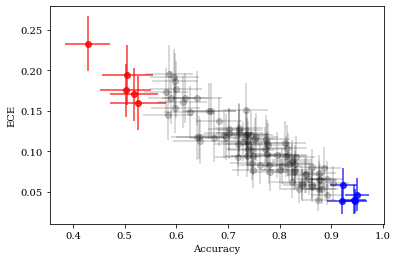

In [38]:
# plot
x = np.mean(accuracy_samples, axis=1)
y = np.mean(ece_samples, axis=1)
xerr = np.std(accuracy_samples, axis=1)
yerr = np.std(ece_samples, axis=1)


k = 5
# most accuracy top k
idx = x.argsort()[-k:][::-1]
plt.errorbar(x[idx], y[idx],
            xerr=xerr[idx],
            yerr=yerr[idx],
            fmt='o', alpha=0.8, color='b')


# least accuracy top k
idx = x.argsort()[:k]
plt.errorbar(x[idx], y[idx],
            xerr=xerr[idx],
            yerr=yerr[idx],
            fmt='o', alpha=0.8, color='r')



# other predicted classes
idx = x.argsort()[10:-k]
plt.errorbar(x[idx], y[idx],
            xerr=xerr[idx],
            yerr=yerr[idx],
            fmt='o', alpha=0.2, color='k')



plt.xlabel('Accuracy')
plt.ylabel('ECE')
plt.show()

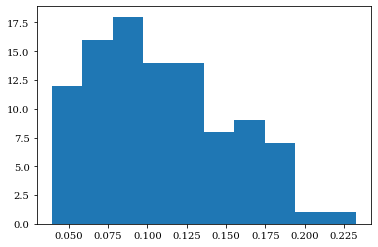

In [6]:
plt.hist(np.mean(ece_samples, axis=1));
plt.show()

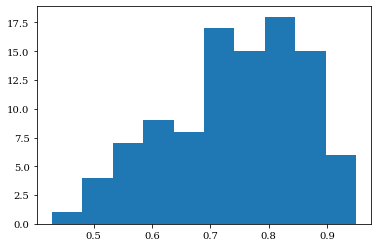

In [7]:
plt.hist(np.mean(accuracy_samples, axis=1));
plt.show()